# Time Series Decomposition

This simple Jupyter Notebook is designed as a practical introduction to time series decomposition.
It is structured in two parts:
1) **Manual implementation:** The reader builds functions from scratch to replicate the core time series components.
2) **Practical decomposition procedure:** Introduction to a typical time series decomposition method to a simple real-world dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dt = 1 # Increment step
t = np.arange(0, 1000, dt) # Complete array of time indices

### Trend
The trend component can be modeled as a simple straight line, such as the following equation: $$y_{trend}(t) = a \cdot t + b$$ where $a$ is the slope of the line and $b$ is the offset 

In [3]:
def linear_trend(x, slope, offset):
    return x*slope + offset

slope = 0.5
offset = 240
trend_component = linear_trend(t, slope, offset)

### Seasonality
A simple sinusoidal signal can serve as a good example of a simple seasonal model. $$y_{season}(t) = A_s \cdot sin(2\pi f_s t + \phi_s)$$ Where $A_s$ is the amplitude, $f_s$ is the frequency of the signal and $\phi_s$ is the phase shift.

In [32]:
def sinusoidal_seasonality(x, amplitude, freq, offset):
    return amplitude*np.sin(2*np.pi*freq*x + offset)

amplitude = 300
period = 120
frequency = 1/period
offset = 2
seasonal_component = sinusoidal_seasonality(t, amplitude, frequency, offset)

### Cycle
The cycle is defined as a pattern with irregular frequencies that are dependent on outside factors. To keep the model simple, I will define it using a cosine function. However, this function will start with one frequency and change to a different frequency at the midpoint of the time series. Assuming the time series has $N$ samples, the cycle is defined as.
$$
y_{cycle}(t) = A_c \cdot cos(2\pi f_ct + \phi_c)
$$ 
where the frequency $f_c$ is given by: 
$$
f_c =\begin{dcases}
f_{c1} & \text{if } t \in [0, \frac{N}{2}]\\
f_{c2} & \text{if } t \in [\frac{N}{2} + 1, N]
\end{dcases}
$$

In this equation, $A_c$ is the amplitude, $f_c$ is the frequency and $\phi_c$ is the phase shift.

In [33]:
def cyclic_cos(x, amplitude, period, offset):
    return amplitude*np.cos(2*np.pi*(1/period)*x + offset)

period_1 = 50
amp_1 = 200
offset_1 = 3

period_2 = 150
amp_2 = 300
offset_2 = 0

period_3 = 200
amp_3 = 10
ofset_3 = 2
cyclic_component = np.concatenate([cyclic_cos(t[:int(len(t)/2)], amp_1, period_1, offset_1), cyclic_cos(t[int(len(t)/2):], amp_2, period_2, offset_2)], axis=0)

### Remainder
The remainder component is generated by sampling from a uniform random distribution within a specified range.
$$
y_{remainder}(t) \sim \mathcal{U}(a, b)
$$
Here, $a$ and $b$ define the lower and upper limits of that range.

In [6]:
def residual_component_as_random_noise(x, low, high):
    return np.random.uniform(low=low, high=high, size=len(x))

low = -50.0
high = 50
residual_component = residual_component_as_random_noise(t, low, high)

### Additive and multiplicative decomposition

In [7]:
additive_decomposition = trend_component + seasonal_component + cyclic_component + residual_component
multiplicative_decomposition = trend_component * seasonal_component * cyclic_component * residual_component

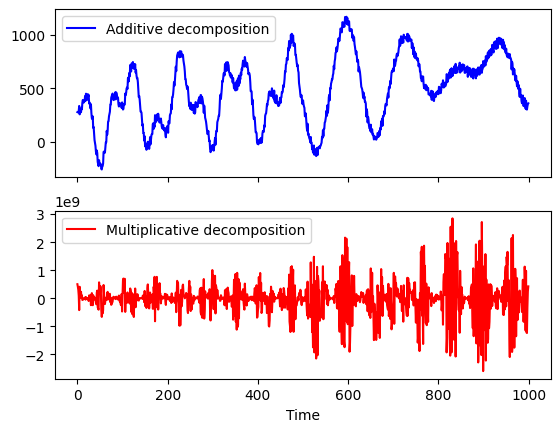

In [8]:
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(t, additive_decomposition, color="blue", label="Additive decomposition")
axs[1].plot(t, multiplicative_decomposition, color="red", label="Multiplicative decomposition")
axs[1].set_xlabel("Time")
axs[0].legend()
axs[1].legend()

### Simple time series decomposition of real world dataset
The data I am using consists of 10 years' worth of daily maximum temperature readings from New York City. In this example, the components of this time series are not known in advance, but luckily there are tools that can help us identify the different components that govern the data. The only thing we have to guess is whether the decomposition is additive or multiplicative.

### Data loading

In [9]:
import requests
import pandas as pd

# Open-Meteo API
url = "https://archive-api.open-meteo.com/v1/archive?latitude=40.78&longitude=-73.97&start_date=2014-01-01&end_date=2023-12-31&daily=temperature_2m_max&timezone=America%2FNew_York"
response = requests.get(url)
data = response.json()

Create a dataset that consists of the date of the measurement and the measurement value

In [24]:
df = pd.DataFrame({
    'date': pd.to_datetime(data['daily']['time']), # Convert to datetime
    'max temperature': data['daily']['temperature_2m_max']
})
df.set_index('date', inplace=True)

df_monthly = df.resample('ME').mean() # Monthly average time series

Plot original data

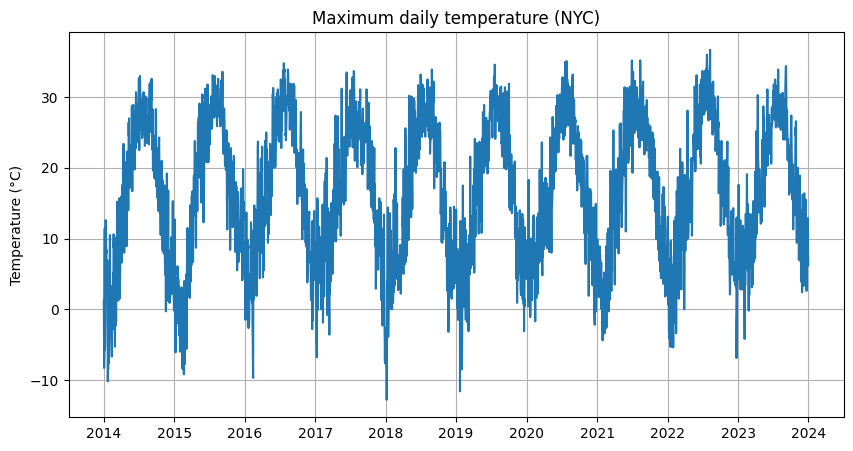

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['max temperature'])
plt.title('Maximum daily temperature (NYC)')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

I assume an additive decomposition and use a Hodrick-Prescott filter to extract the cyclical component from the trend. Check this link for a quick rundown on how the filter works https://medium.com/@iamryanahmad/hodrick-prescott-hp-filter-8c5acb35aa04. 

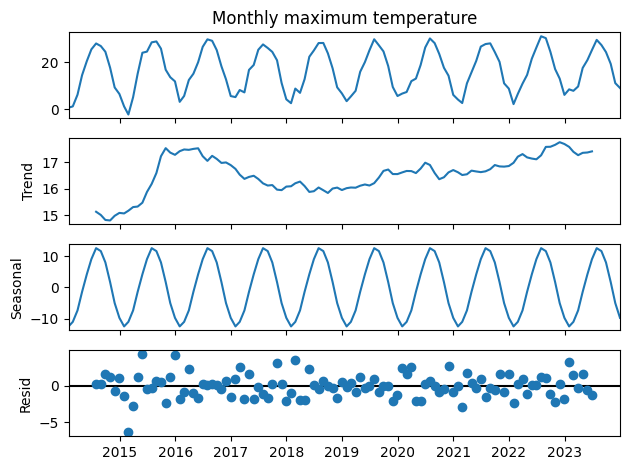

In [30]:
from statsmodels.tsa.api import seasonal_decompose
from statsmodels.tsa.filters.hp_filter import hpfilter

# Rename column name
df_monthly = df_monthly.rename(columns={"max temperature": "Monthly maximum temperature"})
# Additive decomposition on the monthly data
decomposition_model = "additive"
# period=12 because we have monthly data with a yearly seasonality
decomposition = seasonal_decompose(df_monthly['Monthly maximum temperature'], model=decomposition_model, period=12)

# Plot
fig = decomposition.plot()
plt.show()

C:\Projects\Time Series Analysis\linkedin-series\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


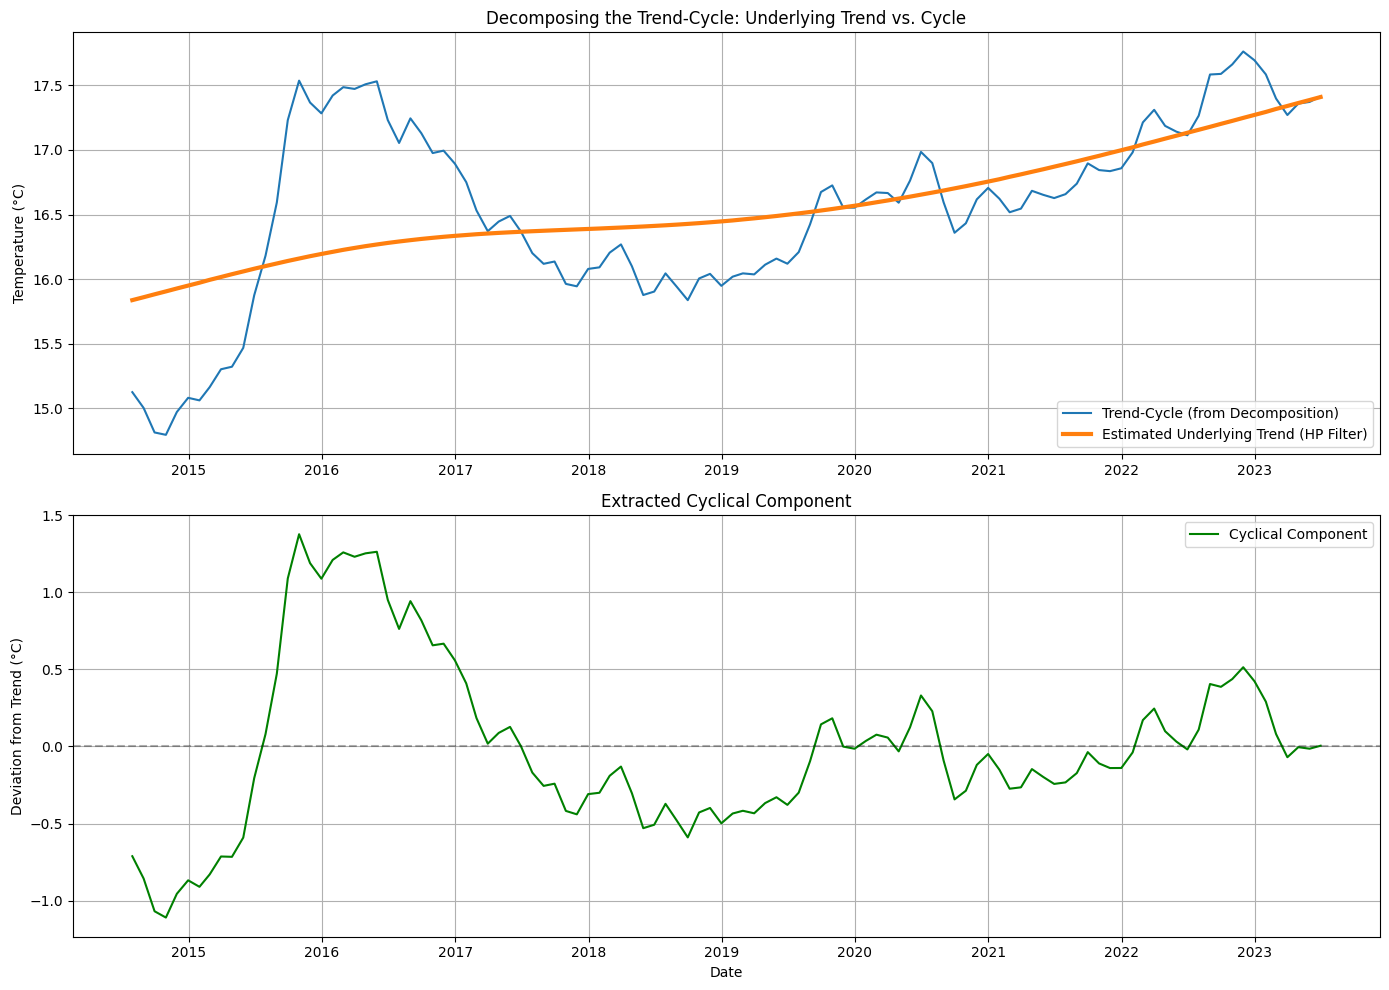

In [31]:
# Get trend component. The trend component in this case is actually trend + cycle
trend_cycle_series = decomposition.trend.dropna() # This is the combined trend + cycle

# Apply the Hodrick-Prescott Filter
# The 'lambda' parameter is a smoothing parameter.
# https://medium.com/@iamryanahmad/hodrick-prescott-hp-filter-8c5acb35aa047
# For monthly data, a common value is lambda = 129600 (see link below)
# https://en.wikipedia.org/wiki/Hodrick%E2%80%93Prescott_filter
cycle, trend = hpfilter(trend_cycle_series, lamb=129_600)

# Create a new DataFrame for our results
results = pd.DataFrame({
    'observed': trend_cycle_series,
    'trend': trend,
    'cycle': cycle
})

# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot Trend-Cycle vs. Estimated Trend
ax1.plot(results.index, results['observed'], label='Trend-Cycle (from Decomposition)')
ax1.plot(results.index, results['trend'], label='Estimated Underlying Trend (HP Filter)', linewidth=3)
ax1.set_title('Decomposing the Trend-Cycle: Underlying Trend vs. Cycle')
ax1.set_ylabel('Temperature (°C)')
ax1.legend()
ax1.grid(True)

# Plot the Cyclical Component
ax2.plot(results.index, results['cycle'], label='Cyclical Component', color='green')
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3) # Add a zero line
ax2.set_title('Extracted Cyclical Component')
ax2.set_ylabel('Deviation from Trend (°C)')
ax2.set_xlabel('Date')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()